In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [3]:
dev = qml.device('lightning.qubit', wires=4)

## Data 

In [4]:
N = 20000

In [5]:
data = np.random.normal(loc=7,scale=1.5, size=N).astype(int)

In [6]:
values, counts = np.unique(data, return_counts=True)

In [7]:
values

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], requires_grad=True)

In [6]:
def num_bin(x):
    return np.array([1 if i == '1' else 0 for i in format(x, '#06b')[2:]])

(0.0, 16.0)

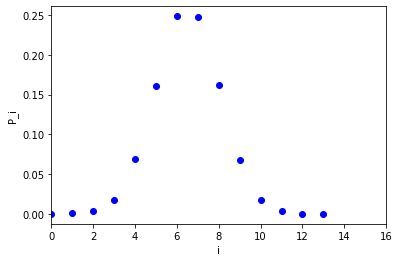

In [7]:
plt.plot(values,counts/N, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')
plt.xlim(0,16)

## Circuit ansatz

generator just a strongly entangling layer

In [8]:
def G_anastz(params, qbits):
    for i in range(4): qml.Hadamard(wires=i)
    qml.StronglyEntanglingLayers(weights=params, wires=[qbits[0],qbits[1],qbits[2],qbits[3]])

circuit for plotting

In [9]:
@qml.qnode(dev)
def circuit2(params, wires):
    G_anastz(params, wires)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_2538110/1974881317.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


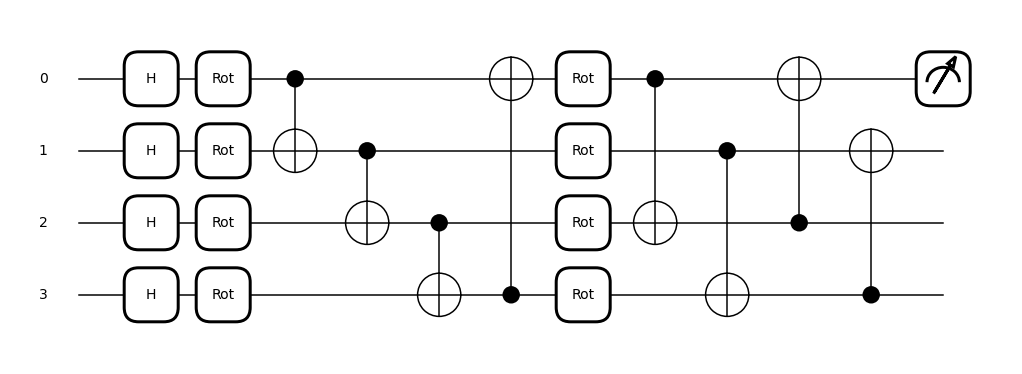

In [10]:
fig, ax = qml.draw_mpl(circuit2)(np.zeros(shape=(2,4,3)), [0,1,2,3])
fig.show()

Trianing circuit just samples form generator

In [11]:
@qml.qnode(dev)
def training_circ(paramsg):
    G_anastz(paramsg, [0,1,2,3])
    #return qml.sample(wires=[0,1,2,3])
    #return [qml.expval(qml.PauliZ(i)) for i in range(4)]
    return qml.probs(wires=[0,1,2,3])

/tmp/ipykernel_2538110/515988293.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


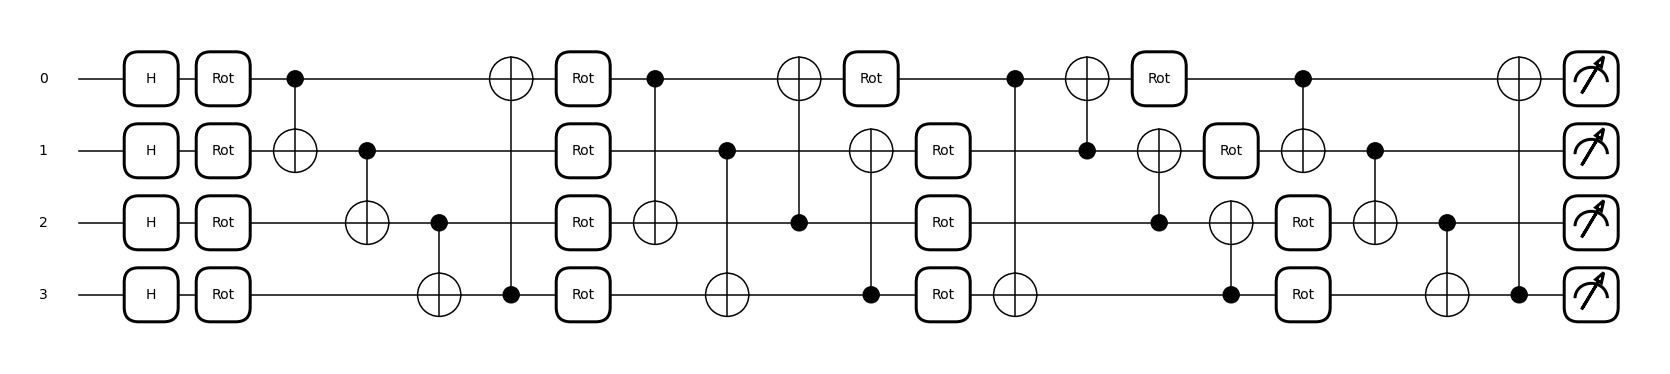

In [12]:
fig, ax = qml.draw_mpl(training_circ)(np.random.random(size=(4,4,3)))
fig.show()

In [13]:
dev_sample = qml.device('lightning.qubit', wires=4, shots=2000)

@qml.qnode(dev_sample)
def training_circ_sample(paramsg):
    G_anastz(paramsg, [0,1,2,3])
    return qml.counts(wires=[0,1,2,3])
    #return [qml.expval(qml.PauliZ(i)) for i in range(4)]

sigmoid activation

In [14]:
def sig(x):
    return 1.0 / (1.0 + np.exp(-x))

Discriminator:
- Idea was to just use a two layer mlp with sigmoid activation
- for some reason if I use np.sum(in_state.astype(np.float64)) I get nonzero gradients
- cast to float is neccessary for numpy

In [15]:
def discriminator(in_state, paramsd):
    # give paramsd as (3,4,2) (which is (width neurons, input dimension, num layers)
    # I take last dim of paramsd as b
    y = sig((paramsd[:4,0,0]*in_state+paramsd[:4,0,2]))
    y = sig(np.dot(paramsd[:10,:4,1],y)+paramsd[:10,1,2])
    y = np.dot(paramsd[:10,1,3].T,y)+paramsd[0,2,3]
    return sig(y)
    # return np.sum(in_state.astype(np.float64))

## Training 

In [16]:
debug_printing = 0

def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch_gen_old(paramsg, paramsd, batch, reg=0.000001):
    # I use log loss to to get proper gradients
    loss = 0.0
    for i in batch:
        f = training_circ(paramsg)
        # maybe recst measurement output to [0,1] ?
        f = (1-f)/2
        loss = loss - discriminator(f, paramsd)
        #loss = loss - discriminator(f, paramsd)
    return loss / len(batch)

def cost_batch_gen(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    probs = training_circ(paramsg)
    for i in range(16):
        loss -= probs[i]*np.log(discriminator(i, paramsd)+reg)
    return loss

def cost_batch_discr_og(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(paramsg)
        f = (1-f)/2
        loss = loss + discriminator(f, paramsd)
        loss = loss - discriminator(num_bin(i), paramsd)
    return loss

def cost_batch_discr(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    probs = training_circ(paramsg)
    values, counts = np.unique(batch, return_counts=True)
    real_vals = np.arange(16)
    real_counts = np.zeros(16)
    indices=np.nonzero(np.isin(real_vals,values))[0]
    real_counts[indices]=counts
    approx_distr = real_counts/len(batch)
    for i in range(16):
        loss -= approx_distr[i]*np.log(discriminator(i, paramsd)+reg)
        loss -= probs[i]*np.log(1-discriminator(i, paramsd)+reg)        
    return loss

In [17]:
# initialize parameters
paramsg = np.random.uniform(-0.5,0.5,size=(8,4,3), requires_grad=True)
paramsd = np.random.uniform(-0.1,0.1,size=(10,4,4), requires_grad=True)

In [18]:
epochs = 2000
batch_size=5000
learning_rate=0.001

In [19]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
optd = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

Training:
- Just loop over data
- Define lambda function for every data batch
- alter between training of generator and discriminator

In [20]:
print("initial paramsg:", paramsg)
print("initial paramsd:", paramsd)

paramsg_before = paramsg.copy()
paramsd_before = paramsd.copy()

losshistg = []
losshistd = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        if it % 2 == 0:
            cost_fn_g = lambda p: cost_batch_gen(p, paramsd, Xbatch)
            paramsg = optg.step(cost_fn_g, paramsg)
        if it % 2 == 1:
            cost_fn = lambda p: cost_batch_discr(paramsg, p, Xbatch)
            paramsd = optd.step(cost_fn, paramsd)
        print(j, end="\r")

    
    lossg = cost_batch_gen(paramsg, paramsd, data)
    lossd = cost_batch_discr(paramsg, paramsd, data)
    
    losshistg += [lossg]
    losshistd += [lossd]
    
    print("____")
    print(f"Epoch: {it} | Gen Loss: {lossg:.3} | Discr Loss: {lossd:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)
print("final paramsd:", paramsd)

initial paramsg: [[[ 0.14984733 -0.08085728  0.05388473]
  [-0.12963418 -0.12294736  0.33594555]
  [-0.49897321  0.47653801 -0.04932388]
  [ 0.04291913  0.26732504  0.46103785]]

 [[-0.00814336 -0.05888257 -0.03643749]
  [ 0.1609275  -0.10291571  0.19748204]
  [ 0.3838447  -0.37955245  0.1738499 ]
  [ 0.38971794 -0.02923847 -0.34469876]]

 [[ 0.2939936  -0.11205496  0.39122614]
  [ 0.30787162  0.31876167  0.4296357 ]
  [-0.26282902  0.09885946  0.10160323]
  [ 0.48241699  0.14352395 -0.09318867]]

 [[ 0.12994528 -0.06410986 -0.33226286]
  [ 0.13786257  0.36003669 -0.01195365]
  [-0.49520379 -0.03705367 -0.27503684]
  [ 0.26293824  0.06619256 -0.41435518]]

 [[ 0.44958262 -0.21940875 -0.22267654]
  [ 0.33854747 -0.26628797  0.06519357]
  [-0.12647256 -0.4160841  -0.00305374]
  [ 0.14425904  0.43758012 -0.3862893 ]]

 [[-0.0174449   0.059846   -0.44292026]
  [-0.33412761  0.38453296  0.27716395]
  [-0.40731725 -0.0610252   0.03489297]
  [-0.12258086  0.08396674 -0.49674247]]

 [[-0.43535

Check loss

Text(0, 0.5, 'loss')

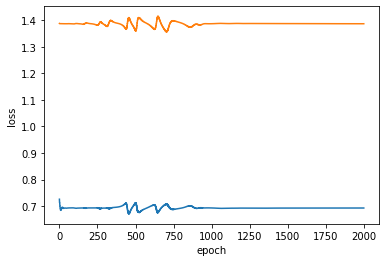

In [21]:
plt.plot(losshistg)
plt.plot(losshistd)
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale('log')

Sample from the generator as test

In [22]:
sample_dev = qml.device('lightning.qubit', wires=4, shots = N)
@qml.qnode(sample_dev)
def sample_test():
    G_anastz(paramsg, [0,1,2,3])
    return qml.sample()

In [23]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [24]:
valuestest, countstest = np.unique(testresult, return_counts=True)

In [25]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

(0.0, 16.0)

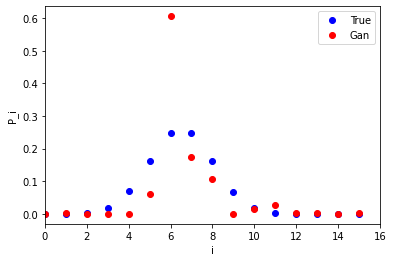

In [26]:
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="Gan")
plt.ylabel('P_i')
plt.xlabel('i')
plt.legend()
plt.xlim(0,16)